# What is A/B Testing?

A/B testing is a set of statistical techniques utilized to evaluate and isolate the impact of a particular feature against a control.


In a business or marketing context this could be testing the effectiveness of one advert against another.

It is a scientific way of quantifying the impact of a change to a website, a product, or a feature.

## When should I run such an experiment?

Eamples of when you might want to utilize A/B testing include:
- Deciding whether or not to launch a new product, or feature
- To quantify the impact of a new feature or product
- When there is a need to compare data with intuition. i.e. are users really responding to my new change?

## 10 steps to setting up an A/B Test
1. Define your goal and form a hypotheses
2. Identify a control and a test group
3. Identify key metrics to measure
4. Identify what data needs to be collected
5. Make sure that appropriate logging is in place to collect all necessary data
6. Determine how small of a difference you would like to detect.
7. Determine what fraction of visitors you want to be in the treatment
8. Run a power analysis to determine how much data you need to collect and how long you should run the test
9. Run the test for *atleast* that duration
10. First time trying something new: run an A/A test (dummy test) simultaneously to check for systematic biases

## Step 1

Where formulating such experiments we have to define a goal. i.e. trying to quanitfy the impact of different CTA buttons, or advertisments.

In this step we also have to define our

- Hypothesis
    - What we are trying to prove, i.e. our new adervertisment is more effective in driving new customers to our website
   
- Null Hypothesis
     - The inverse of the hypothesis and the assumed awnser when we cannot validate our hypothesis.

## NOTES on A/B TESTING

[The Math Behind A/B Testing](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)

Before running a test its good to know the ***baseline conversion rate*** and ***desired lift***

For our example lets imagine that we currently a ***sign up rate of 10%*** for our users and we would like to see if our modified signup for will result in at least a ***2% increase*** in our sign up rate


In [128]:
bcr = .10
d_hat = .12

Typically, the total number of users participating in the A/B test make up a small percentage of the total amount of users. Users are randomly selected and assigned to either a control group or a test group. The sample size that you decide on will determine how long you might have to wait until you have collected enough.

Initially, we will collect *1000 users* for *each group* and serve the current signup page to the control group and a new signup page to the test group.

A = Control / B = Test

Cell below hidden - generates dummy A/B data to test with

In [129]:
import scipy.stats as scs
import pandas as pd
# import numpy as np


def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    # distribute events based on proportion of group size
    group_bern = scs.bernoulli(N_A / (N_A + N_B))

    # initiate bernoulli distributions from which to randomly sample
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [170]:
import numpy as np
n_of_A = 1000
n_of_B = 1000

ab_data = generate_data(n_of_A, n_of_B, bcr, d_hat)

In [171]:
ab_summary = ab_data.pivot_table(values='converted',index='group',aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values='converted', index='group', aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_summary.converted/ab_summary.total
ab_summary

,converted,total,rate
group,,,
A,95,999,0.095095
B,131,1001,0.130869


## Understanding the likelihood of a Boolean Outcome:
 
To get a better understanding of what what we are trying to access in an A/B test, it is good to do a quick refresher on binomial distributions.

We can do this by first checking out wikipedia : [Binomial Distribution](https://en.wikipedia.org/wiki/Binomial_distribution)

**Wikipedia ("Official Description")**:

According to wikipedia a binomial distribution is a ***discrete probability distribution*** of the number of successes (our boolean condition = True,1,yes...) that we have in a sequence of ***'n' independant experiments***.

**In python talk**:

A list of likelihoods that we will have a ***particular number of positive results*** in a ***given number of trials*** - note the sum of these likelihoods should equate to ~ 100% / 1

If we want to calculate and visualize the binomial distribution for a given experiment we can do so using scipy.stats (scs) and numpy (np)


In [207]:
import matplotlib.pyplot as plt
A_converted = ab_summary['converted']['A']
A_total  = ab_summary['total']['A']
B_converted = ab_summary['converted']['B']
B_total  = ab_summary['total']['B']
A_conversion_rate = ab_summary['rate']['A']
B_conversion_rate = ab_summary['rate']['B']

Text(0, 0.5, 'probability')

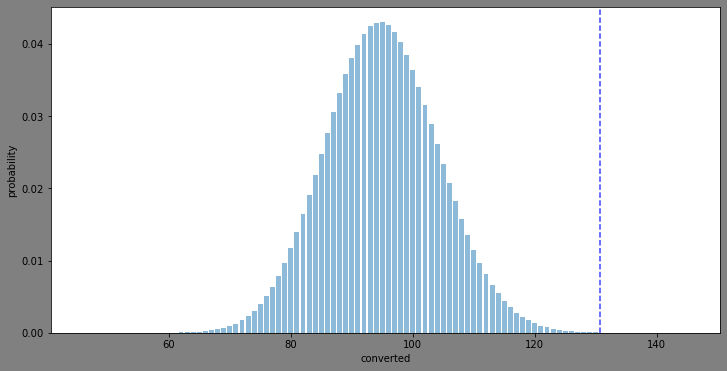

In [173]:
fig, ax = plt.subplots(figsize=(12,6),facecolor='grey')
x = np.linspace(A_converted-49, A_converted+50, 100)
y = scs.binom(A_total, A_conversion_rate).pmf(x)
ax.bar(x, y, alpha=0.5)
ax.axvline(x=B_conversion_rate * A_total, c='blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')


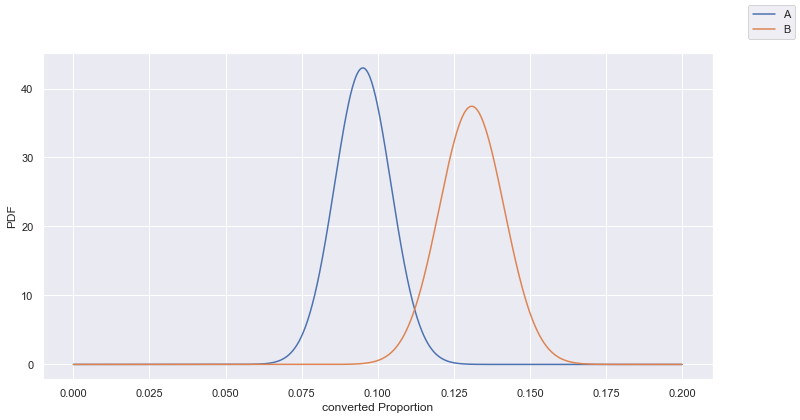

In [220]:
fig, ax = plt.subplots(figsize=(12,6))

#standard error of the mean for both groups 
SE_A = np.sqrt(A_conversion_rate * (1-A_conversion_rate)) / np.sqrt(A_total)
SE_B = np.sqrt(B_conversion_rate * (1-B_conversion_rate)) / np.sqrt(B_total)

x = np.linspace(0, .2, 1000) #first two args are relative to conversion rate, the last one is the number of trials

yA = scs.norm(A_conversion_rate, SE_A).pdf(x)
ax.plot(x, yA)

scs.norm(B_conversion_rate, SE_B).pdf(x)
yB =
ax.plot(x, yB)
plt.xlabel('converted Proportion')
plt.ylabel('PDF')

plt.figlegend(labels=('A','B'),loc='upper right')